# 2kr Analysis

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product, chain, combinations
from scipy import stats
from IPython.display import display, HTML
%matplotlib inline

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

## Config

In [2]:
inputFile = 'test-scalars.csv'
repetitionsCount = -1 # -1 = auto-detect
factors = ['R', 'T', 'm', 'D']

tIntervalAlpha = 0.95

plotSize = (10, 10)
plotStyle = 'seaborn-whitegrid'
plotErrorBars = True
saveFigures = False

# Filter scalars
scalarsFilter = ['Floorplan.userCount', 'Floorplan.coveredUsers:sum', 'Floorplan.collisions:sum', 'Floorplan.activityTime:last']
# Performance indexes
perfIndexes = [
    ('coveredUsersPercent', 'percentage of covered users'),
    ('Floorplan.collisions:sum', 'total number of collisions'),
    ('Floorplan.activityTime:last', 'total broadcast time'),
]

## Load scalars

In [3]:
df = pd.read_csv('exported_data/' + inputFile, converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray,
})

In [4]:
if repetitionsCount <= 0: # auto-detect
    repetitionsCount = int(df[df.attrname == 'repetition']['attrvalue'].max()) + 1
print('Repetitions:', repetitionsCount)

# Computed
factorsCount = len(factors)
configsCount = 2**factorsCount
totalSims = configsCount*repetitionsCount

combinedFactors = list(chain(*[list(map(''.join, combinations(''.join(factors), i))) for i in range(1, factorsCount+1)]))
freedomDegrees = configsCount*(repetitionsCount - 1)


display(HTML("<style>div.output_scroll { height: auto; max-height: 48em; }</style>"))
pd.set_option('display.max_rows', totalSims)
pd.set_option('display.max_columns', 2*configsCount*repetitionsCount+1)
if saveFigures:
    os.makedirs('figures', exist_ok=True)

Repetitions: 10


In [5]:
scalars = df[(df.type == 'scalar') | ((df.type == 'itervar') & (df.attrname != 'TO')) | ((df.type == 'param') & (df.attrname == 'Floorplan.userCount')) | ((df.type == 'runattr') & (df.attrname == 'repetition'))]
scalars = scalars.assign(qname = scalars.attrname.combine_first(scalars.module + '.' + scalars.name))
scalars.value = scalars.value.combine_first(scalars.attrvalue.astype('float64'))
scalars_wide = scalars.pivot_table(index=['run'], columns='qname', values='value')
scalars_wide.sort_values([*factors, 'repetition'], inplace=True)
count = 0
for index in scalars_wide.index:
    config = count // repetitionsCount
    scalars_wide.loc[index, 'config'] = config
    count += 1
scalars_wide = scalars_wide[['config', 'repetition', *factors, *scalarsFilter]]

In [6]:
# coverage
scalars_wide['coveredUsersPercent'] = scalars_wide['Floorplan.coveredUsers:sum'] / (scalars_wide['Floorplan.userCount'] - 1)

## 2kr

In [7]:
cols = ['exp', 'I'] + combinedFactors
data = [[e, 1] + list(chain(*[list(map(np.prod, combinations(r, i))) for i in range(1, len(r)+1)])) for r,e in zip([list(x) for x in product([-1, 1], repeat=factorsCount)], range(0, configsCount))]
factorsMatrix = pd.DataFrame.from_records(data, columns=cols, index='exp')

computeMatrices = []
ciMatrices = []
errorVariances = []

for perfIndex, perfIndexDesc in perfIndexes:
    print("2^k*r analysis for the", perfIndexDesc)
    cols = ['exp'] + ['y' + str(i) for i in range(0, repetitionsCount)]
    data = [[i] + scalars_wide[scalars_wide.config == i][perfIndex].values.tolist() for i in range(0, configsCount)]
    ysMatrix = pd.DataFrame.from_records(data, columns=cols, index='exp')
    ysMatrix['mean'] = ysMatrix.mean(axis=1)
    for r in range(0, repetitionsCount):
        ysMatrix['e' + str(r)] = ysMatrix['y' + str(r)] - ysMatrix['mean']

    matrix = pd.concat([factorsMatrix, ysMatrix], axis=1)

    computeCols = ['idx', 'I'] + combinedFactors + ['e' + str(r) for r in range(0, repetitionsCount)]
    data = [['Sum'], ['Mean (Qi)'], ['SSQ']]
    SSE = 0
    for col in computeCols[1:]:
        sumvalue = np.sum(matrix[col].values * matrix['mean'].values)
        data[0].append(sumvalue)
        data[1].append(sumvalue / configsCount)
        if col in ['e' + str(r) for r in range(0, repetitionsCount)]:
            ssq = np.sum(matrix[col].values * matrix[col].values)
            data[2].append(ssq)
            SSE += ssq
        else:
            data[2].append('')
    computeMatrix = pd.DataFrame.from_records(data, columns=computeCols, index='idx')

    data = [['(2^k)*r*(qi)^2'], ['Variation'], ['Variation%']]
    SST = SSE
    for col in combinedFactors:
        qi = computeMatrix.loc['Mean (Qi)', col]
        r2kqi2 = configsCount*repetitionsCount*(qi**2)
        data[0].append(r2kqi2)
        SST += r2kqi2
    data[0].append(SSE)
    idx = 1
    for col in combinedFactors:
        r2kqi2 = data[0][idx]
        var = r2kqi2 / SST
        data[1].append(var)
        data[2].append('{:.2%}'.format(var))
        idx += 1
    data[1].append(SST)
    data[2].append('{:.2%}'.format(SSE/SST))
    resultMatrix = pd.DataFrame.from_records(data, columns=['idx'] + combinedFactors + ['SSE/SST'], index='idx')

    errorVariance = SSE / freedomDegrees
    negativeInterval, positiveInterval = tuple(v*math.sqrt(errorVariance/(configsCount*repetitionsCount)) for v in stats.t.interval(tIntervalAlpha, freedomDegrees))
    data = [['CI+ Qi ({:.2%})'.format(tIntervalAlpha)], ['CI- Qi ({:.2%})'.format(tIntervalAlpha)], ['Distance (Qi)'], ['Zero Included'], ['CI+ Variation'], ['CI- Variation'], ['CI Distance (Variation)']]
    for col in combinedFactors:
        qi = computeMatrix.loc['Mean (Qi)', col]
        upper = qi + positiveInterval
        lower = qi + negativeInterval
        data[0].append(upper)
        data[1].append(lower)
        data[2].append(abs(upper - lower))
        data[3].append(upper >= 0 and lower <= 0)
        upper = (configsCount*repetitionsCount*(upper**2))/SST
        lower = (configsCount*repetitionsCount*(lower**2))/SST
        data[4].append(upper)
        data[5].append(lower)
        data[6].append(abs(upper - lower))
    ciMatrix = pd.DataFrame.from_records(data, columns=['idx'] + combinedFactors, index='idx')

    computeMatrices.append(computeMatrix)
    ciMatrices.append(ciMatrix)
    errorVariances.append(errorVariance)

    display(matrix)
    display(computeMatrix)
    display(resultMatrix)
    display(ciMatrix)

    print('SSE =', SSE)
    print('SST =', SST)
    print('Error variance =', errorVariance)
    print('Unexplained Variation =', '{:.2%}'.format(SSE/SST))
    print()
    print('####################################')
    print()

2^k*r analysis for the percentage of covered users


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,0.933868,0.955912,0.933868,0.921844,0.913828,0.929860,0.947896,0.941884,0.965932,0.935872,0.938076,-0.004208,0.017836,-0.004208,-0.016232,-0.024248,-0.008216,0.009820,0.003808,0.027856,-0.002204
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,1.000000,0.997996,0.995992,0.997996,0.993988,0.991984,0.991984,0.995992,1.000000,0.997996,0.996393,0.003607,0.001603,-0.000401,0.001603,-0.002405,-0.004409,-0.004409,-0.000401,0.003607,0.001603
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,0.979960,0.981964,0.967936,0.959920,0.977956,0.965932,0.963928,0.959920,0.987976,0.969940,0.971543,0.008417,0.010421,-0.003607,-0.011623,0.006413,-0.005611,-0.007615,-0.011623,0.016433,-0.001603
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,0.993988,0.995992,0.995992,0.993988,0.991984,0.997996,0.997996,0.995992,1.000000,0.997996,0.996192,-0.002204,-0.000200,-0.000200,-0.002204,-0.004208,0.001804,0.001804,-0.000200,0.003808,0.001804
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,0.967936,0.933868,0.929860,0.963928,0.957916,0.921844,0.969940,0.961924,0.927856,0.937876,0.947295,0.020641,-0.013427,-0.017435,0.016633,0.010621,-0.025451,0.022645,0.014629,-0.019439,-0.009419
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,0.997996,1.000000,1.000000,0.993988,0.991984,0.995992,0.995992,1.000000,0.997996,0.997996,0.997194,0.000802,0.002806,0.002806,-0.003206,-0.005210,-0.001202,-0.001202,0.002806,0.000802,0.000802
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,0.993988,0.985972,0.971944,0.991984,0.997996,0.991984,0.991984,0.995992,0.981964,0.993988,0.989780,0.004208,-0.003808,-0.017836,0.002204,0.008216,0.002204,0.002204,0.006212,-0.007816,0.004208
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,0.763527,0.731463,0.611222,0.857715,0.769539,0.723447,0.763527,0.677355,0.753507,0.799599,0.745090,0.018437,-0.013627,-0.133868,0.112625,0.024449,-0.021643,0.018437,-0.067735,0.008417,0.054509


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,14.536874,-1.136072,0.356112,0.367735,0.515631,0.291984,0.210621,0.229459,0.154108,0.302806,-0.382966,0.13006,0.348497,-0.236273,-0.093988,-0.081964,-0.012633,0.228686,-0.104137,0.101275,-0.216374,-0.158599,-0.221141,0.066011,-0.030382,0.347293
Mean (Qi),0.908555,-0.071005,0.022257,0.022983,0.032227,0.018249,0.013164,0.014341,0.009632,0.018925,-0.023935,0.008129,0.021781,-0.014767,-0.005874,-0.005123,-0.000790,0.014293,-0.006509,0.006330,-0.013523,-0.009912,-0.013821,0.004126,-0.001899,0.021706
SSQ,,,,,,,,,,,,,,,,,0.027466,0.017232,0.025557,0.018425,0.021243,0.009243,0.100958,0.017483,0.006202,0.061503


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,0.806662,0.07926,0.084518,0.166172,0.053284,0.027726,0.032907,0.014843,0.057307,0.091664,0.010572,0.075906,0.03489,0.005521,0.004199,0.305311
Variation,0.435858,0.042826,0.045667,0.089787,0.028791,0.014981,0.01778,0.00802,0.030964,0.049528,0.005712,0.041014,0.018852,0.002983,0.002269,1.850745
Variation%,43.59%,4.28%,4.57%,8.98%,2.88%,1.50%,1.78%,0.80%,3.10%,4.95%,0.57%,4.10%,1.89%,0.30%,0.23%,16.50%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.063809,0.029452,0.030179,0.039422,0.025444,0.020359,0.021536,0.016827,0.026121,-0.01674,0.015324,0.028976,-0.007572,0.001321,0.002072
CI- Qi (95.00%),-0.0782,0.015062,0.015788,0.025032,0.011054,0.005969,0.007146,0.002437,0.01173,-0.031131,0.000934,0.014586,-0.021962,-0.013069,-0.012318
Distance (Qi),0.01439,0.01439,0.01439,0.01439,0.01439,0.01439,0.01439,0.01439,0.01439,0.01439,0.01439,0.01439,0.01439,0.01439,0.01439
Zero Included,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True
CI+ Variation,0.351999,0.074991,0.078736,0.134355,0.055969,0.035833,0.040098,0.024479,0.058985,0.024227,0.020301,0.072587,0.004956,0.000151,0.000371
CI- Variation,0.528669,0.019612,0.02155,0.05417,0.010563,0.00308,0.004415,0.000513,0.011895,0.083781,0.000075,0.018392,0.041699,0.014767,0.013117
CI Distance (Variation),0.17667,0.055379,0.057186,0.080186,0.045406,0.032754,0.035683,0.023965,0.047089,0.059555,0.020226,0.054195,0.036743,0.014616,0.012746


SSE = 0.3053108220448913
SST = 1.8507445502226905
Error variance = 0.0021202140419784117
Unexplained Variation = 16.50%

####################################

2^k*r analysis for the total number of collisions


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,465.0,517.0,524.0,512.0,549.0,580.0,499.0,506.0,526.0,525.0,520.3,-55.3,-3.3,3.7,-8.3,28.7,59.7,-21.3,-14.3,5.7,4.7
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,278.0,265.0,289.0,293.0,355.0,296.0,326.0,321.0,265.0,227.0,291.5,-13.5,-26.5,-2.5,1.5,63.5,4.5,34.5,29.5,-26.5,-64.5
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,614.0,641.0,611.0,645.0,625.0,625.0,673.0,648.0,655.0,617.0,635.4,-21.4,5.6,-24.4,9.6,-10.4,-10.4,37.6,12.6,19.6,-18.4
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,360.0,297.0,323.0,370.0,343.0,358.0,284.0,382.0,324.0,339.0,338.0,22.0,-41.0,-15.0,32.0,5.0,20.0,-54.0,44.0,-14.0,1.0
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,407.0,502.0,506.0,433.0,487.0,507.0,461.0,442.0,528.0,460.0,473.3,-66.3,28.7,32.7,-40.3,13.7,33.7,-12.3,-31.3,54.7,-13.3
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,193.0,237.0,206.0,269.0,270.0,215.0,209.0,216.0,227.0,173.0,221.5,-28.5,15.5,-15.5,47.5,48.5,-6.5,-12.5,-5.5,5.5,-48.5
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,647.0,655.0,631.0,607.0,620.0,672.0,631.0,658.0,628.0,598.0,634.7,12.3,20.3,-3.7,-27.7,-14.7,37.3,-3.7,23.3,-6.7,-36.7
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,387.0,455.0,412.0,375.0,423.0,413.0,396.0,419.0,384.0,429.0,409.3,-22.3,45.7,2.7,-34.3,13.7,3.7,-13.3,9.7,-25.3,19.7
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,1182.0,1288.0,1274.0,813.0,972.0,1081.0,1072.0,1292.0,1146.0,804.0,1092.4,89.6,195.6,181.6,-279.4,-120.4,-11.4,-20.4,199.6,53.6,-288.4


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,16030.3,8982.3,-745.7,2754.1,805.5,-652.9,1732.5,2812.3,530.5,-500.5,312.1,155.3,-598.5,396.5,656.9,466.9,1.033772e+06,1.363871e+06,417254.650000,-502658.450000,-355975.750000,-9924.750000,-659170.650000,-449569.950000,431915.550000,-1.269513e+06
Mean (Qi),1001.89375,561.39375,-46.60625,172.13125,50.34375,-40.80625,108.28125,175.76875,33.15625,-31.28125,19.50625,9.70625,-37.40625,24.78125,41.05625,29.18125,6.461075e+04,8.524193e+04,26078.415625,-31416.153125,-22248.484375,-620.296875,-41198.165625,-28098.121875,26994.721875,-7.934459e+04
SSQ,,,,,,,,,,,,,,,,,1.851357e+05,2.530119e+05,243741.350000,339023.550000,288738.150000,92730.150000,217721.950000,292566.550000,381843.550000,2.297205e+05


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,50426070.80625,347542.80625,4740666.75625,405518.90625,266424.00625,1875972.65625,4943144.55625,175893.90625,156562.65625,60879.00625,15073.80625,223876.40625,98257.65625,269698.50625,136247.25625,2524233.5
Variation,0.756398,0.005213,0.071111,0.006083,0.003996,0.02814,0.074148,0.002638,0.002348,0.000913,0.000226,0.003358,0.001474,0.004046,0.002044,66666063.19375
Variation%,75.64%,0.52%,7.11%,0.61%,0.40%,2.81%,7.41%,0.26%,0.23%,0.09%,0.02%,0.34%,0.15%,0.40%,0.20%,3.79%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),582.082623,-25.917377,192.820123,71.032623,-20.117377,128.970123,196.457623,53.845123,-10.592377,40.195123,30.395123,-16.717377,45.470123,61.745123,49.870123
CI- Qi (95.00%),540.704877,-67.295123,151.442377,29.654877,-61.495123,87.592377,155.079877,12.467377,-51.970123,-1.182623,-10.982623,-58.095123,4.092377,20.367377,8.492377
Distance (Qi),41.377746,41.377746,41.377746,41.377746,41.377746,41.377746,41.377746,41.377746,41.377746,41.377746,41.377746,41.377746,41.377746,41.377746,41.377746
Zero Included,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False
CI+ Variation,0.813176,0.001612,0.089232,0.01211,0.000971,0.03992,0.09263,0.006958,0.000269,0.003878,0.002217,0.000671,0.004962,0.00915,0.005969
CI- Variation,0.701675,0.010869,0.055044,0.002111,0.009076,0.018414,0.05772,0.000373,0.006482,0.000003,0.000289,0.0081,0.00004,0.000996,0.000173
CI Distance (Variation),0.111501,0.009257,0.034188,0.009999,0.008105,0.021506,0.03491,0.006585,0.006213,0.003874,0.001928,0.007429,0.004922,0.008154,0.005796


SSE = 2524233.4999999995
SST = 66666063.19375001
Error variance = 17529.39930555555
Unexplained Variation = 3.79%

####################################

2^k*r analysis for the total broadcast time


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,33.0,30.0,37.0,24.0,35.0,34.0,29.0,32.0,35.0,35.0,32.4,0.6,-2.4,4.6,-8.4,2.6,1.6,-3.4,-0.4,2.6,2.6
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,43.0,51.0,39.0,50.0,49.0,42.0,47.0,55.0,60.0,44.0,48.0,-5.0,3.0,-9.0,2.0,1.0,-6.0,-1.0,7.0,12.0,-4.0
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,36.0,43.0,33.0,35.0,32.0,29.0,40.0,36.0,32.0,33.0,34.9,1.1,8.1,-1.9,0.1,-2.9,-5.9,5.1,1.1,-2.9,-1.9
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,52.0,38.0,41.0,64.0,51.0,51.0,54.0,47.0,53.0,54.0,50.5,1.5,-12.5,-9.5,13.5,0.5,0.5,3.5,-3.5,2.5,3.5
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,101.0,89.0,87.0,90.0,121.0,100.0,103.0,84.0,94.0,108.0,97.7,3.3,-8.7,-10.7,-7.7,23.3,2.3,5.3,-13.7,-3.7,10.3
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,147.0,102.0,135.0,94.0,121.0,117.0,135.0,115.0,118.0,121.0,120.5,26.5,-18.5,14.5,-26.5,0.5,-3.5,14.5,-5.5,-2.5,0.5
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,76.0,74.0,95.0,77.0,101.0,95.0,88.0,68.0,114.0,109.0,89.7,-13.7,-15.7,5.3,-12.7,11.3,5.3,-1.7,-21.7,24.3,19.3
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,85.0,114.0,92.0,118.0,110.0,104.0,112.0,108.0,117.0,106.0,106.6,-21.6,7.4,-14.6,11.4,3.4,-2.6,5.4,1.4,10.4,-0.6
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,13.0,10.0,11.0,8.0,7.0,10.0,10.0,9.0,12.0,8.0,9.8,3.2,0.2,1.2,-1.8,-2.8,0.2,0.2,-0.8,2.2,-1.8


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,753.8,-406.8,312.8,-5.6,80.6,-184.6,28.2,-61.2,-30.6,9.6,-17.6,23.2,-7.4,-5.8,-10.2,1.6,32.80,-3665.90000,-1139.600,-2630.800,3641.8000,-729.200,2295.4000,-3204.00,2820.8,2578.70000
Mean (Qi),47.1125,-25.425,19.55,-0.35,5.0375,-11.5375,1.7625,-3.825,-1.9125,0.6,-1.1,1.45,-0.4625,-0.3625,-0.6375,0.1,2.05,-229.11875,-71.225,-164.425,227.6125,-45.575,143.4625,-200.25,176.3,161.16875
SSQ,,,,,,,,,,,,,,,,,1416.80,1076.20000,840.600,1616.000,796.8000,203.800,469.6000,876.40,976.8,571.00000


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,103428.9,61152.4,19.6,4060.225,21298.225,497.025,2340.9,585.225,57.6,193.6,336.4,34.225,21.025,65.025,1.6,8844.0
Variation,0.509663,0.301338,0.000097,0.020007,0.10495,0.002449,0.011535,0.002884,0.000284,0.000954,0.001658,0.000169,0.000104,0.00032,0.000008,202935.975
Variation%,50.97%,30.13%,0.01%,2.00%,10.50%,0.24%,1.15%,0.29%,0.03%,0.10%,0.17%,0.02%,0.01%,0.03%,0.00%,4.36%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-24.200394,20.774606,0.874606,6.262106,-10.312894,2.987106,-2.600394,-0.687894,1.824606,0.124606,2.674606,0.762106,0.862106,0.587106,1.324606
CI- Qi (95.00%),-26.649606,18.325394,-1.574606,3.812894,-12.762106,0.537894,-5.049606,-3.137106,-0.624606,-2.324606,0.225394,-1.687106,-1.587106,-1.862106,-1.124606
Distance (Qi),2.449212,2.449212,2.449212,2.449212,2.449212,2.449212,2.449212,2.449212,2.449212,2.449212,2.449212,2.449212,2.449212,2.449212,2.449212
Zero Included,False,False,True,False,False,False,False,False,True,True,False,True,True,True,True
CI+ Variation,0.461749,0.340272,0.000603,0.030917,0.083854,0.007035,0.005331,0.000373,0.002625,0.000012,0.00564,0.000458,0.000586,0.000272,0.001383
CI- Variation,0.559941,0.264769,0.001955,0.011462,0.128412,0.000228,0.020104,0.007759,0.000308,0.00426,0.00004,0.002244,0.001986,0.002734,0.000997
CI Distance (Variation),0.098193,0.075503,0.001352,0.019455,0.044558,0.006807,0.014772,0.007386,0.002317,0.004248,0.0056,0.001786,0.0014,0.002462,0.000386


SSE = 8844.000000000002
SST = 202935.975
Error variance = 61.41666666666668
Unexplained Variation = 4.36%

####################################



## Performance plot

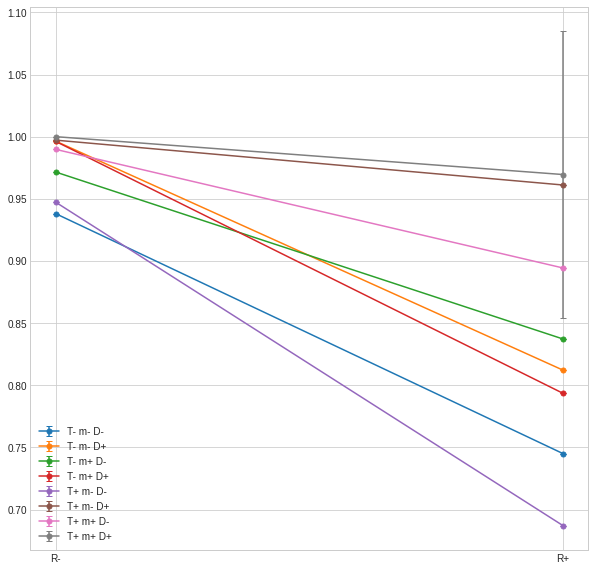

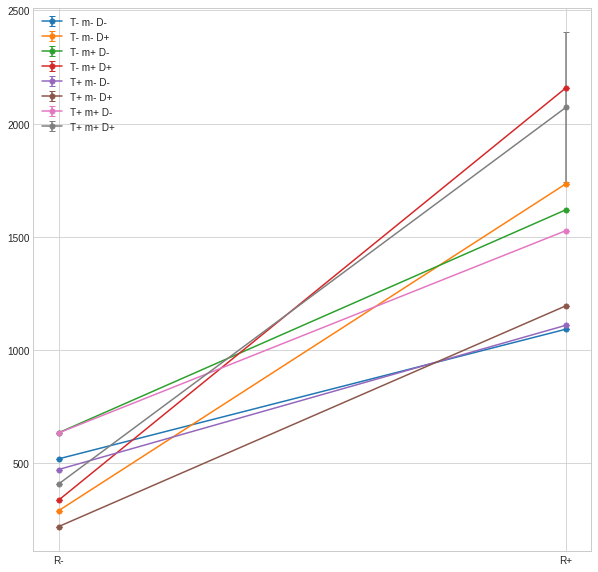

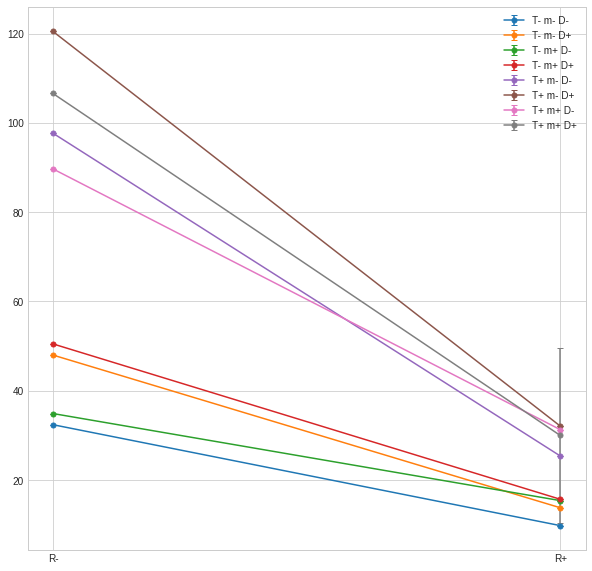

In [8]:
xarr = np.array([-1, 1])
idx = 0
for perfIndex, perfIndexDesc in perfIndexes:
    ys = []
    es = []
    fs = []
    for cfg in range(0, configsCount):
        y = np.sum(factorsMatrix.loc[cfg, ['I'] + combinedFactors].values * computeMatrices[idx].loc['Mean (Qi)', ['I'] + combinedFactors].values)
        highy = np.sum(factorsMatrix.loc[cfg, combinedFactors].values * ciMatrices[idx].loc['CI+ Qi ({:.2%})'.format(tIntervalAlpha), combinedFactors].values)
        _, positiveInterval = tuple(v*math.sqrt(errorVariances[idx]/(configsCount*repetitionsCount)) for v in stats.t.interval(tIntervalAlpha, freedomDegrees))
        q0 = computeMatrices[idx].loc['Mean (Qi)']['I']
        highy += q0 + positiveInterval
        fs.append(' '.join([f + str('+' if factorsMatrix.loc[cfg][f] == 1 else '-') for f in factors[1:]]))
        ys.append(y)
        es.append(highy - y)

    plt.figure(figsize=plotSize)
    plt.style.use(plotStyle)
    plt.xticks(xarr, (factors[0] + '-', factors[0] + '+'))
    ys = [y for y in zip(ys[:configsCount//2], ys[configsCount//2:])]
    es = [e for e in zip(es[:configsCount//2], es[configsCount//2:])]
    for y, e, lbl in zip(ys, es, fs):
        yarr = np.array(y)
        earr = np.array(e)
        if plotErrorBars:
            plt.errorbar(x=xarr, y=yarr, yerr=earr, capsize=3, linestyle='-', marker='.', markersize=10, label=lbl)
        else:
            plt.plot(xarr, yarr, linestyle='-', marker='.', markersize=10, label=lbl)
    if saveFigures:
        fig = plt.gcf()
        fig.savefig('figures/' + varname + '-perfplot.png')
    plt.legend()
    plt.show()
    idx += 1